In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [8]:
# If this code block complains, comment it out

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [20]:
import nltk
import gensim
import re
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

# For MAC OS
mallet_path = 'mallet-2.0.8/bin/mallet'
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

# For Windows OS
#os.environ['MALLET_HOME'] = 'C:\\mallet'
#mallet_path = 'C:\\mallet\\bin\\mallet.bat'

In [10]:
def readFile(folder, filename):
    fileData = ""
    file = open(folder + "/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [128]:
def createEmptyFile(filename):
    file = open("authors/" + filename, 'w').close()

In [129]:
def saveToFile(filename, abstract):
    if len(abstract) > 12:
        file = open("authors/" + filename, 'a')
        try:
            file.writelines(abstract + "\n")
        except:
            file.write("\n")
            print("\n Write exception")
        file.close
        print('+', end='')
        return True
    else:
        print('-', end='')
        return False

# TODO
* change to (2000,2021)
* change to (2011,2021) for css
* append authors
* fix blankspace problem with authors in USENIX

In [133]:
corpus = []

# Used later to make diagrams
yearList = []
conferenceList = []
author = []

for i in range (2012,2021):
    conference = readFile('abstracts', 'usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('Usenix')
        yearList.append(i)
    authors = readFile('authors', 'usenix' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
for i in range (2012,2021):
    conference = readFile('abstracts', 'css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('CSS')
        yearList.append(i)
    authors = readFile('authors', 'css' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)     
for i in range (2000,2021):   
    conference = readFile('abstracts', 'ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('IEEE')
        yearList.append(i)
    authors = readFile('authors', 'ieee' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
for i in range (2012,2021):
    conference = readFile('abstracts', 'ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('NDSS')
        yearList.append(i)
    authors = readFile('authors', 'ndss' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

# Save the years and conferences in a Panda table
df_year_conf = pd.DataFrame(np.column_stack((yearList, conferenceList)), columns=['Year', 'Conf'])

#df_year_conf
   
#print(author)    
#print(corpus)
print(len(corpus))
print(len(author))

4175
4152


## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [12]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [56]:
stop_words = ['achieve',
 'address',
 'analysis',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

def remove_ourStopwords(doc):
    return " ".join([word for word in doc.split() if word not in stop_words])

In [57]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda b: remove_stopwords(b),         # Removes stopwords 
    lambda c: remove_ourStopwords(c)       # Removes our stopwords
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]


In [52]:
corpus_clean

[['online',
  'sale',
  'counterfeit',
  'unauthorized',
  'product',
  'drive',
  'robust',
  'underground',
  'advertising',
  'industry',
  'email',
  'spam',
  'black',
  'search',
  'engine',
  'optimization',
  'forum',
  'abuse',
  'virtually',
  'encounter',
  'enticement',
  'purchase',
  'drug',
  'prescription',
  'free',
  'online',
  'canadian',
  'pharmacy',
  'site',
  'clearly',
  'economically',
  'motivate',
  'shape',
  'underlie',
  'business',
  'enterprise',
  'understood',
  'precisely',
  'underground',
  'exploit',
  'rare',
  'opportunity',
  'view',
  'organizations—the',
  'glavmed',
  'spamit',
  'promotion',
  'pharmaceutical',
  'affiliate',
  'inside',
  'ground',
  'truth',
  'data',
  'year',
  'transaction',
  'cover',
  'sale',
  'depth',
  'empirical',
  'analysis',
  'worldwide',
  'consumer',
  'demand',
  'role',
  'independent',
  'party',
  'advertiser',
  'detailed',
  'cost',
  'accounting',
  'overall',
  'business',
  'model'],
 ['tradition

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [58]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [59]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

### Making the tfidf model
Not in use for LDA Mallet

In [60]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Finding optimal number of topics
Machinelearingplus.com approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        print(num_topics)
        
    return model_list, coherence_values

### Coherence score over topics, Stepping every 4th
Stepping from 2 to 104 with a step length of 4

In [27]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=104, start=2, step=4)

2
6


KeyboardInterrupt: 

In [ ]:
coherence_values = [0.3250157403264292, 0.4116900808150424, 0.4277707176143622, 0.4419215919328382, 0.43300547700202796, 0.43331531510788773, 0.4507613241261437, 0.4401537362798364, 0.4436828004648704, 0.4321437701507225, 0.4287353256235635, 0.4345214971377863, 0.4207751964079457, 0.42903262376408574, 0.41356412264891634, 0.4094172711686478, 0.41385811506381215, 0.3971588021061537, 0.4020413137080951, 0.3944484660319797, 0.40475857425077855, 0.4043484985706639, 0.40233617235048474, 0.39983668071530726, 0.39050519443737175]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=102; start=2; step=4;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

In [98]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.325
Num Topics = 6  has Coherence Value of 0.4117
Num Topics = 10  has Coherence Value of 0.4278
Num Topics = 14  has Coherence Value of 0.4419
Num Topics = 18  has Coherence Value of 0.433
Num Topics = 22  has Coherence Value of 0.4333
Num Topics = 26  has Coherence Value of 0.4508
Num Topics = 30  has Coherence Value of 0.4402
Num Topics = 34  has Coherence Value of 0.4437
Num Topics = 38  has Coherence Value of 0.4321
Num Topics = 42  has Coherence Value of 0.4287
Num Topics = 46  has Coherence Value of 0.4345
Num Topics = 50  has Coherence Value of 0.4208
Num Topics = 54  has Coherence Value of 0.429
Num Topics = 58  has Coherence Value of 0.4136
Num Topics = 62  has Coherence Value of 0.4094
Num Topics = 66  has Coherence Value of 0.4139
Num Topics = 70  has Coherence Value of 0.3972
Num Topics = 74  has Coherence Value of 0.402
Num Topics = 78  has Coherence Value of 0.3944
Num Topics = 82  has Coherence Value of 0.4048
Num Topics = 86  ha

#### Result
This gives us the top highest coherence score:
- Num Topics = 26  has Coherence Value of 0.4508

### Coherence score over topics, Stepping every one
Now we want to be more exact but since the coherence is dropping with higher number of topics we reduce the upper limit.

Now we try to step from 2 to 70 on every value

In [68]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=30, start=10, step=1)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [69]:
coherence_values

[0.45741016711736143,
 0.43812237500413626,
 0.44700166760394505,
 0.4237243991755197,
 0.44138174061651375,
 0.47246420353643387,
 0.44475081862744803,
 0.4629257166589516,
 0.4586327146019771,
 0.4650390691639515,
 0.4507273100240664,
 0.46749012598310075,
 0.4522999250325796,
 0.44682130158115224,
 0.4681677957401466,
 0.43720424619327247,
 0.4646445062416126,
 0.4537427883096004,
 0.45912247985383015,
 0.441672999809767]

In [70]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4574
Num Topics = 3  has Coherence Value of 0.4381
Num Topics = 4  has Coherence Value of 0.447
Num Topics = 5  has Coherence Value of 0.4237
Num Topics = 6  has Coherence Value of 0.4414
Num Topics = 7  has Coherence Value of 0.4725
Num Topics = 8  has Coherence Value of 0.4448
Num Topics = 9  has Coherence Value of 0.4629
Num Topics = 10  has Coherence Value of 0.4586
Num Topics = 11  has Coherence Value of 0.465
Num Topics = 12  has Coherence Value of 0.4507
Num Topics = 13  has Coherence Value of 0.4675
Num Topics = 14  has Coherence Value of 0.4523
Num Topics = 15  has Coherence Value of 0.4468
Num Topics = 16  has Coherence Value of 0.4682
Num Topics = 17  has Coherence Value of 0.4372
Num Topics = 18  has Coherence Value of 0.4646
Num Topics = 19  has Coherence Value of 0.4537
Num Topics = 20  has Coherence Value of 0.4591
Num Topics = 21  has Coherence Value of 0.4417


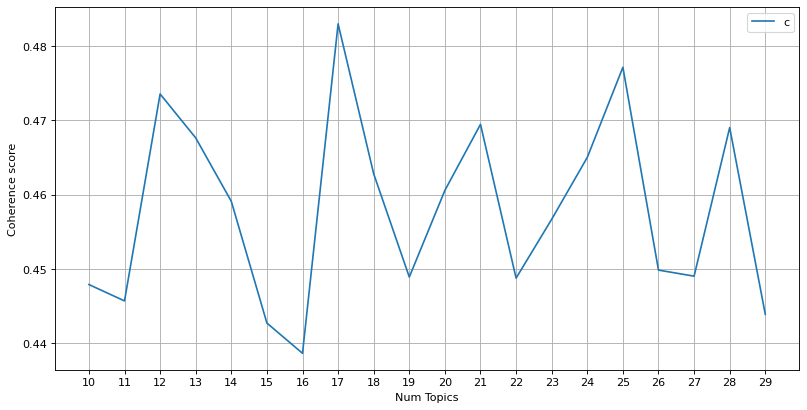

In [65]:
#coherence_values = [0.32571064083112744, 0.3537344947550003, 0.38589689375318126, 0.39384185450287246, 0.3968198253781281, 0.4085182731090585, 0.42127183913002364, 0.41899078263050016, 0.42801836357265693, 0.4309421068656622, 0.4235910756450276, 0.4516905876830981, 0.44230979084842603, 0.4296217041847969, 0.4312776000207533, 0.42955783914286844, 0.4300818857106711, 0.43599484572542013, 0.4288093062032049, 0.431145903679033, 0.45102550720523704, 0.4408525746026434, 0.43442023864813467, 0.437182271259546, 0.44709664105064434, 0.44248557145575135, 0.42246041004330903, 0.43784503147185494, 0.43667989244832234, 0.4351125576380536, 0.43902968092362493, 0.4440178347094399, 0.4271598549200618, 0.43617684419539876, 0.43125821112489443, 0.4329721336785587, 0.43217676681552086, 0.43310381516722185, 0.45072485690785824, 0.4401630451262257, 0.43130301356185136, 0.4334126436221655, 0.421009575540349, 0.4272964973804624, 0.4350421319148597, 0.4233540568965465, 0.4350122511003696, 0.43232603003979947, 0.41460403500831033, 0.42528017344333635, 0.4267933944574832, 0.4276083290805306, 0.4232434154417294, 0.4289482978832848, 0.4148342197092429, 0.4184389211956406, 0.4167830014416288, 0.41978178212929607, 0.40395936537564947, 0.40763329977423757, 0.421859133976826, 0.4079528877973058, 0.408300929971383, 0.41109076687251356, 0.4171141990155899, 0.40615382099134045, 0.4129390628617565, 0.40967900018905035]
coherence_values = [0.44791042556593086,
 0.44570386836410053,
 0.47357193355966426,
 0.46765378557318316,
 0.4591103114392938,
 0.44272426183711105,
 0.43865037957549907,
 0.48301381051033115,
 0.4628169743109464,
 0.4489204210874405,
 0.4605920384492901,
 0.46948401083986,
 0.4487734898353356,
 0.4567002420273789,
 0.46502981317091924,
 0.47716428768132146,
 0.44985512886666634,
 0.4490382019262274,
 0.46904895734035923,
 0.4439065928128975]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=30; start=10; step=1;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

#### Result
This gives us:
- Num Topics = 13  has Coherence Value of 0.4517
- Num Topics = 21  has Coherence Value of 0.4311
- Num Topics = 40  has Coherence Value of 0.4507

And one can see that we now have three good candidates in the number of topics

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [61]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=17,
                                             id2word=dictionary)

In [62]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('application', 0.06002093144950288),
   ('input', 0.03956043956043956),
   ('generate', 0.0315541601255887),
   ('test', 0.031030873888016744),
   ('type', 0.024646781789638934),
   ('automatically', 0.017896389324960755),
   ('case', 0.01575091575091575),
   ('generation', 0.014913657770800628),
   ('error', 0.014861329147043432),
   ('check', 0.014338042909471481)]),
 (4,
  [('performance', 0.02948245473481814),
   ('evaluation', 0.023500507397318807),
   ('current', 0.01789243176841318),
   ('case', 0.01719809859531058),
   ('improve', 0.016183303957699086),
   ('good', 0.016183303957699086),
   ('strategy', 0.015756022005020562),
   ('issue', 0.01367302248571276),
   ('significant', 0.013459381509373498),
   ('important', 0.013138920044864605)]),
 (2,
  [('protocol', 0.10034585454894802),
   ('secure', 0.0431357479104621),
   ('party', 0.03227975790181574),
   ('computation', 0.030502449803055047),
   ('communication', 0.017821116341627436),
   ('transaction', 0.014698818

## Setting upp the lda model
Used insted of LDA mallet

In [26]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(tfidf_M1, 
                num_topics=2, 
                id2word = dictionary, 
                passes=18, 
                random_state =0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Multicore

In [27]:
Lda = gensim.models.ldamulticore.LdaMulticore
lda_model = Lda(tfidf_M1 , 
                num_topics=8, 
                id2word = dictionary, 
                passes=15,
                random_state =0,
                workers=4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=corpus_clean_bigram, 
                                     dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6364102700593359


In [25]:
topics = lda_model.print_topics(num_topics=100, num_words=6)

for topic in topics:
    print(topic)

(0, '0.001*"abstract" + 0.001*"available" + 0.001*"flash" + 0.001*"rpki" + 0.001*"skimmer" + 0.001*"walkie_talkie"')
(1, '0.001*"helios" + 0.001*"prêt_voter" + 0.001*"volte" + 0.001*"coercion" + 0.001*"sanctum" + 0.001*"guis"')
(2, '0.002*"captchas" + 0.001*"rust" + 0.001*"captcha" + 0.001*"pill" + 0.001*"spurious" + 0.000*"macs"')
(3, '0.002*"workshop" + 0.001*"proverif" + 0.001*"quic" + 0.001*"meltdown" + 0.001*"protocol" + 0.001*"snarks"')
(4, '0.002*"rowhammer" + 0.001*"deduplication" + 0.001*"printer" + 0.001*"uninitialized" + 0.001*"spamming" + 0.001*"spammer"')
(5, '0.004*"attack" + 0.003*"user" + 0.003*"protocol" + 0.003*"data" + 0.003*"security" + 0.002*"network"')
(6, '0.001*"recommender" + 0.001*"bliss" + 0.001*"sdns" + 0.001*"journalist" + 0.000*"fake_visitations" + 0.000*"court"')
(7, '0.001*"vault" + 0.001*"crowdturfing" + 0.001*"fitness" + 0.001*"compartmentalization" + 0.001*"kerberos" + 0.001*"ethos"')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualisation of topics
First creating a lda mallet model and then visualising

In [63]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [24]:
print(dictionary)

Dictionary(16152 unique tokens: ['abuse', 'accounting', 'advertiser', 'advertising', 'affiliate']...)


In [64]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.170313  0.095869       1        1  6.023554
6     -0.162587 -0.096393       2        1  6.010522
14    -0.043468 -0.088182       3        1  6.001845
12     0.061498  0.151149       4        1  5.989430
16    -0.081375  0.098736       5        1  5.911602
5     -0.167448 -0.035180       6        1  5.890275
15     0.080694  0.191207       7        1  5.881974
13     0.289476 -0.096728       8        1  5.878343
11    -0.139971 -0.156959       9        1  5.874334
3     -0.078002  0.251435      10        1  5.856774
9     -0.060745 -0.171547      11        1  5.841836
4      0.031886 -0.104632      12        1  5.840742
8      0.093924 -0.118434      13        1  5.833672
10    -0.041992  0.091902      14        1  5.832712
0     -0.092993 -0.024431      15        1  5.803079
7     -0.097860  0.089307      16        1  5.795536
2      0.238649 -0.077120      17        1  5.733769, topic_info=             Term         Freq        Total Category  logprob  loglift
177        attack  5787.000000  5787.000000  Default  30.0000  30.0000
173          user  3372.000000  3372.000000  Default  29.0000  29.0000
14           data  3867.000000  3867.000000  Default  28.0000  28.0000
343       network  2194.000000  2194.000000  Default  27.0000  27.0000
103      protocol  2033.000000  2033.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
702     adversary   154.759562   716.698862  Topic17  -4.8747   1.3260
31    independent    96.359727   188.800305  Topic17  -5.3485   2.1862
560    efficiency   105.119702   272.153887  Topic17  -5.2614   1.9075
1783   complexity    98.306388   235.397960  Topic17  -5.3285   1.9856
837         small   101.226380   443.991930  Topic17  -5.2992   1.3804

[1331 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
769       8  1.026779      abstractly
0         3  0.349400           abuse
0         6  0.637141           abuse
0        11  0.013702           abuse
1937     12  1.006040        academic
...     ...       ...             ...
66        5  0.180389            year
66        6  0.321693            year
66        9  0.141304            year
66       11  0.006013            year
2618      8  1.004457  zero_knowledge

[2047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 15, 13, 17, 6, 16, 14, 12, 4, 10, 5, 9, 11, 1, 8, 3])

In [38]:
stop_words = ['achieve',
 'address',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']
stop_words.sort()
stop_words

['achieve',
 'address',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

# Panda

In [66]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)


## Topic distribution over all documents

In [67]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df


Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0     0.057576  0.059014  0.057438  0.062410  0.059490  0.059461  0.060498   
1     0.064631  0.058127  0.058180  0.062031  0.057555  0.058872  0.058090   
2     0.060592  0.061146  0.062315  0.057376  0.059630  0.057508  0.059379   
3     0.057110  0.060979  0.059824  0.057578  0.059881  0.058798  0.056401   
4     0.054657  0.063344  0.057831  0.052982  0.058249  0.055133  0.061331   
...        ...       ...       ...       ...       ...       ...       ...   
4170  0.058984  0.055679  0.052055  0.068485  0.054996  0.058588  0.059003   
4171  0.057938  0.057175  0.056974  0.056823  0.058155  0.059545  0.069033   
4172  0.057711  0.064304  0.058965  0.062137  0.059081  0.057370  0.060816   
4173  0.056166  0.056595  0.057369  0.055492  0.055989  0.058089  0.060185   
4174  0.065254  0.051511  0.048548  0.056533  0.062631  0.051748  0.063653   

       Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
0     0.056148  0.057654  0.059428  0.057188  0.056864  0.063816  0.056773   
1     0.057733  0.060459  0.058122  0.055001  0.054408  0.058759  0.061710   
2     0.057886  0.054135  0.057803  0.057847  0.061168  0.055719  0.057806   
3     0.055837  0.062673  0.054428  0.063716  0.057350  0.064229  0.058323   
4     0.059964  0.064379  0.059625  0.056573  0.057627  0.061047  0.057121   
...        ...       ...       ...       ...       ...       ...       ...   
4170  0.060864  0.056732  0.055451  0.053850  0.063477  0.056378  0.053169   
4171  0.060403  0.058693  0.051404  0.054968  0.058989  0.057974  0.067744   
4172  0.052616  0.058135  0.056639  0.058601  0.060011  0.059843  0.055925   
4173  0.056996  0.057206  0.057132  0.057220  0.060296  0.065575  0.059264   
4174  0.056082  0.056428  0.046616  0.059322  0.064069  0.072388  0.056962   

      Topic_14  Topic_15  Topic_16  
0     0.058265  0.062387  0.055590  
1     0.054898  0.062975  0.058449  
2     0.058954  0.061758  0.058978  
3     0.055273  0.056088  0.061511  
4     0.059128  0.057581  0.063429  
...        ...       ...       ...  
4170  0.060728  0.068834  0.062726  
4171  0.057944  0.057034  0.059203  
4172  0.059919  0.056641  0.061284  
4173  0.066540  0.061903  0.057984  
4174  0.071319  0.047700  0.069237  

[4175 rows x 17 columns]

## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [68]:
lda_mallet_model.get_document_topics(M1[1],minimum_probability=0)

[(0, 0.06463524),
 (1, 0.058099158),
 (2, 0.058184575),
 (3, 0.062028095),
 (4, 0.057586826),
 (5, 0.058830306),
 (6, 0.058128454),
 (7, 0.057732478),
 (8, 0.06043717),
 (9, 0.05811228),
 (10, 0.05500008),
 (11, 0.054398227),
 (12, 0.05877745),
 (13, 0.0617267),
 (14, 0.054887336),
 (15, 0.06297564),
 (16, 0.05846004)]

In [69]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            12.0              0.0638   
1            1             0.0              0.0646   
2            2             2.0              0.0624   
3            3            12.0              0.0642   
4            4             8.0              0.0644   
5            5             1.0              0.0641   
6            6             6.0              0.0691   
7            7             1.0              0.0640   
8            8            14.0              0.0667   
9            9             1.0              0.0639   

                                            Keywords  \
0  model, data, privacy, algorithm, information, ...   
1  code, vulnerability, program, analysis, softwa...   
2  protocol, secure, party, computation, communic...   
3  model, data, privacy, algorithm, information, ...   
4  server, client, query, search, public, standar...   
5  data, authentication, access, file, operation,...   
6  browser, website, content, extension, popular,...   
7  data, authentication, access, file, operation,...   
8  attack, attacker, defense, exploit, target, vi...   
9  data, authentication, access, file, operation,...   

                                                Text  
0  [online, sale, counterfeit, unauthorized, prod...  
1  [traditional, spam, detection, rely, content, ...  
2  [quantify, effect, unsolicited, email, spam, b...  
3  [explore, robustness, usability, moving, image...  
4  [help, user, create, strong, text, password, s...  
5  [practical, algorithm, exploit, randomness, vu...  
6  [vulnerabilities, browser, extension, user, ri...  
7  [browser, mediate, access, valuable, private, ...  
8  [cryptographic, rely, secrecy, cryptographic, ...  
9  [brain, interface, increasingly, popular, gami...

In [70]:
corpus[6]

'Vulnerabilities in browser extensions put users at risk by providing a way for website and network attackers to gain access to users’ private data and credentials. Extensions can also introduce vulnerabilities into the websites that they modify. In 2009, Google Chrome introduced a new extension platform with several features intended to prevent and mitigate extension vulnerabilities: strong isolation between websites and extensions, privilege separation within an extension, and an extension permission system. We performed a security review of 100 Chrome extensions and found 70 vulnerabilities across 40 extensions. Given these vulnerabilities, we evaluate how well each of the security mechanisms defends against extension vulnerabilities. We find that the mechanisms mostly succeed at preventing web attacks, but new security mechanisms are needed to protect users from network attacks on extensions, website metadata attacks on extensions, and vulnerabilities that extensions add to website

## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [71]:
# Group top 5 corpuses under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.0813   
1         1.0              0.0913   
2         2.0              0.0699   
3         3.0              0.0794   
4         4.0              0.0749   
5         5.0              0.0785   
6         6.0              0.0841   
7         7.0              0.0754   
8         8.0              0.0754   
9         9.0              0.0905   
10       10.0              0.0699   
11       11.0              0.0819   
12       12.0              0.0935   
13       13.0              0.0835   
14       14.0              0.0947   
15       15.0              0.0871   
16       16.0              0.0806   

                                             Keywords  \
0   code, vulnerability, program, analysis, softwa...   
1   data, authentication, access, file, operation,...   
2   protocol, secure, party, computation, communic...   
3   user, privacy, android, information, apps, app...   
4   performance, evaluation, current, case, improv...   
5   detect, malicious, malware, detection, domain,...   
6   browser, website, content, extension, popular,...   
7   device, physical, sensor, signal, power, human...   
8   server, client, query, search, public, standar...   
9   network, traffic, internet, host, layer, messa...   
10  application, input, generate, test, type, auto...   
11  password, analysis, event, participant, point,...   
12  model, data, privacy, algorithm, information, ...   
13  scheme, cryptographic, property, proof, signat...   
14  attack, attacker, defense, exploit, target, vi...   
15  memory, channel, hardware, software, applicati...   
16  policy, framework, research, access, challenge...   

                                                 Text  
0   [oblivious, random, access, machine, oram, all...  
1   [enterprises, significant, fraction, host, con...  
2   [bitcoin, ranked, cryptocurrency, experience, ...  
3   [reducing, user, burden, underlie, traditional...  
4   [operation, disrupt, cybercrime, involve, mali...  
5   [blockchain, produce, block, constant, average...  
6   [data, attack, dynamic, script, environment, c...  
7   [applying, modern, fuzzers, novel, target, luc...  
8   [subvert, advance, perimeter, host, attacker, ...  
9   [cyber, defense, evolve, physical, electronic,...  
10  [newly, discover, path, sequence, inference, a...  
11  [core, popular, proxy, circumvention, privatel...  
12  [smart_contract, lucrative, profitable, target...  
13  [highly, interactive, important, driver, moder...  
14  [generation, scam, emerge, voice, impersonatio...  
15  [fear, retribution, victim, crime, willing, vi...  
16  [cross_origin, inference, cosi, attack, attack...

## Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [72]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Topics_Contribution')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords.reset_index(level=0, inplace=True)
topic_num_keywords.columns = ['Document_ID', 'Dominant_Topic', 'Topic_Keywords']

# Concatenate Column wise
df_dominant_topics_contribution = pd.merge(dominant_topic_list, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])
df_dominant_topics = pd.merge(topic_num_keywords, df_dominant_topics_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Sort by Document ID
df_dominant_topics = df_dominant_topics.sort_values(by=['Document_ID']).reset_index(drop=True).drop('Document_ID', axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Change to integer
df_dominant_topics['Dominant_Topic'] = df_dominant_topics['Dominant_Topic'].astype(np.int64)

# Add year and conference
df_document_per_topic = df_dominant_topics.join(df_year_conf)

# Show
df_document_per_topic

Dominant_Topic                                     Topic_Keywords  \
0                 12  model, data, privacy, algorithm, information, ...   
1                  0  code, vulnerability, program, analysis, softwa...   
2                  2  protocol, secure, party, computation, communic...   
3                 12  model, data, privacy, algorithm, information, ...   
4                  8  server, client, query, search, public, standar...   
...              ...                                                ...   
4170              15  memory, channel, hardware, software, applicati...   
4171               6  browser, website, content, extension, popular,...   
4172               1  data, authentication, access, file, operation,...   
4173              14  attack, attacker, defense, exploit, target, vi...   
4174              12  model, data, privacy, algorithm, information, ...   

      Num_Documents  Perc_Documents  Year    Conf  
0               408          0.0977  2012  Usenix  
1               114          0.0273  2012  Usenix  
2                86          0.0206  2012  Usenix  
3               408          0.0977  2012  Usenix  
4               187          0.0448  2012  Usenix  
...             ...             ...   ...     ...  
4170            210          0.0503  2020    NDSS  
4171            498          0.1193  2020    NDSS  
4172            478          0.1145  2020    NDSS  
4173            442          0.1059  2020    NDSS  
4174            408          0.0977  2020    NDSS  

[4175 rows x 6 columns]

### Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [73]:
df = df_year_conf.join(topic_distribution_df)
df

Year    Conf   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4  \
0     2012  Usenix  0.057576  0.059014  0.057438  0.062410  0.059490   
1     2012  Usenix  0.064631  0.058127  0.058180  0.062031  0.057555   
2     2012  Usenix  0.060592  0.061146  0.062315  0.057376  0.059630   
3     2012  Usenix  0.057110  0.060979  0.059824  0.057578  0.059881   
4     2012  Usenix  0.054657  0.063344  0.057831  0.052982  0.058249   
...    ...     ...       ...       ...       ...       ...       ...   
4170  2020    NDSS  0.058984  0.055679  0.052055  0.068485  0.054996   
4171  2020    NDSS  0.057938  0.057175  0.056974  0.056823  0.058155   
4172  2020    NDSS  0.057711  0.064304  0.058965  0.062137  0.059081   
4173  2020    NDSS  0.056166  0.056595  0.057369  0.055492  0.055989   
4174  2020    NDSS  0.065254  0.051511  0.048548  0.056533  0.062631   

       Topic_5   Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
0     0.059461  0.060498  0.056148  0.057654  0.059428  0.057188  0.056864   
1     0.058872  0.058090  0.057733  0.060459  0.058122  0.055001  0.054408   
2     0.057508  0.059379  0.057886  0.054135  0.057803  0.057847  0.061168   
3     0.058798  0.056401  0.055837  0.062673  0.054428  0.063716  0.057350   
4     0.055133  0.061331  0.059964  0.064379  0.059625  0.056573  0.057627   
...        ...       ...       ...       ...       ...       ...       ...   
4170  0.058588  0.059003  0.060864  0.056732  0.055451  0.053850  0.063477   
4171  0.059545  0.069033  0.060403  0.058693  0.051404  0.054968  0.058989   
4172  0.057370  0.060816  0.052616  0.058135  0.056639  0.058601  0.060011   
4173  0.058089  0.060185  0.056996  0.057206  0.057132  0.057220  0.060296   
4174  0.051748  0.063653  0.056082  0.056428  0.046616  0.059322  0.064069   

      Topic_12  Topic_13  Topic_14  Topic_15  Topic_16  
0     0.063816  0.056773  0.058265  0.062387  0.055590  
1     0.058759  0.061710  0.054898  0.062975  0.058449  
2     0.055719  0.057806  0.058954  0.061758  0.058978  
3     0.064229  0.058323  0.055273  0.056088  0.061511  
4     0.061047  0.057121  0.059128  0.057581  0.063429  
...        ...       ...       ...       ...       ...  
4170  0.056378  0.053169  0.060728  0.068834  0.062726  
4171  0.057974  0.067744  0.057944  0.057034  0.059203  
4172  0.059843  0.055925  0.059919  0.056641  0.061284  
4173  0.065575  0.059264  0.066540  0.061903  0.057984  
4174  0.072388  0.056962  0.071319  0.047700  0.069237  

[4175 rows x 19 columns]

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
Year                                                                         
2000  0.058723  0.059529  0.057582  0.058692  0.057977  0.058817  0.058866   
2001  0.057343  0.060084  0.057851  0.058650  0.058785  0.059138  0.059063   
2002  0.058210  0.060109  0.057115  0.057690  0.057800  0.059787  0.059206   
2003  0.057449  0.060305  0.057170  0.058779  0.058561  0.059337  0.058257   
2004  0.057630  0.060381  0.057932  0.059245  0.058564  0.058125  0.058614   
2005  0.057528  0.060303  0.058496  0.057856  0.059157  0.058043  0.058231   
2006  0.058455  0.059659  0.057761  0.058058  0.058912  0.057950  0.059556   
2007  0.057735  0.060445  0.057880  0.058451  0.058981  0.058840  0.058968   
2008  0.058243  0.060348  0.058689  0.058811  0.058522  0.058501  0.060962   
2009  0.058685  0.060265  0.058155  0.058416  0.058564  0.058470  0.059673   
2010  0.058553  0.060689  0.058098  0.058283  0.057964  0.058569  0.060237   
2011  0.058621  0.060309  0.057475  0.058489  0.058479  0.057504  0.059464   
2012  0.058183  0.059985  0.057855  0.058567  0.058469  0.058895  0.059403   
2013  0.058371  0.059863  0.057853  0.058370  0.058524  0.058791  0.059725   
2014  0.058219  0.059736  0.057766  0.058795  0.058674  0.058650  0.059817   
2015  0.058048  0.060266  0.057492  0.058669  0.058454  0.058975  0.060129   
2016  0.058078  0.060281  0.057366  0.058510  0.058482  0.059034  0.059766   
2017  0.058271  0.059889  0.057554  0.058711  0.058272  0.058830  0.059797   
2018  0.058121  0.059884  0.057628  0.058317  0.058497  0.059118  0.059827   
2019  0.057991  0.060065  0.057617  0.058594  0.058506  0.058825  0.060030   
2020  0.058093  0.060127  0.057155  0.058534  0.058538  0.059007  0.060067   

       Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
Year                                                                         
2000  0.058047  0.058064  0.059344  0.058443  0.058364  0.060373  0.059363   
2001  0.058104  0.059676  0.058806  0.059041  0.059511  0.059428  0.058292   
2002  0.057816  0.059370  0.059372  0.058379  0.059482  0.059377  0.059216   
2003  0.058786  0.058687  0.057913  0.058542  0.059326  0.059405  0.059464   
2004  0.057236  0.058966  0.058831  0.058138  0.059449  0.059296  0.060327   
2005  0.058174  0.058764  0.058706  0.058551  0.060220  0.059519  0.058958   
2006  0.058519  0.057885  0.059200  0.058160  0.059361  0.059459  0.058793   
2007  0.057511  0.058149  0.058952  0.058644  0.058846  0.059874  0.059003   
2008  0.058260  0.057719  0.058288  0.058627  0.057709  0.059699  0.059134   
2009  0.058317  0.058736  0.058971  0.057825  0.058890  0.059267  0.059365   
2010  0.057341  0.058874  0.059302  0.058260  0.058789  0.059918  0.058506   
2011  0.058548  0.057655  0.058156  0.058745  0.059157  0.059831  0.059077   
2012  0.058332  0.058558  0.058268  0.058435  0.058758  0.059674  0.059030   
2013  0.058245  0.058507  0.058625  0.058389  0.058796  0.059576  0.058910   
2014  0.058169  0.058540  0.058331  0.058444  0.058624  0.059634  0.058984   
2015  0.058077  0.058393  0.058316  0.058429  0.058566  0.059849  0.058875   
2016  0.057980  0.058474  0.058212  0.058489  0.058983  0.060002  0.058924   
2017  0.058254  0.058447  0.058458  0.058495  0.058729  0.059639  0.058790   
2018  0.058268  0.058712  0.058397  0.058531  0.058806  0.059591  0.058800   
2019  0.058013  0.058382  0.058660  0.058400  0.058613  0.059740  0.058735   
2020  0.058035  0.058382  0.058267  0.058304  0.058982  0.059772  0.058605   

      Topic_14  Topic_15  Topic_16  
Year                                
2000  0.060530  0.058629  0.058655  
2001  0.058976  0.058340  0.058911  
2002  0.058894  0.058603  0.059574  
2003  0.059591  0.059745  0.058684  
2004  0.058462  0.059883  0.058919  
2005  0.059093  0.059373  0.059027  
2006  0.060560  0.058066  0.059647  
2007  0.059457  0.058836  0.059428  
2008  0.059473  0.058099  0.058916  
2009  0.05

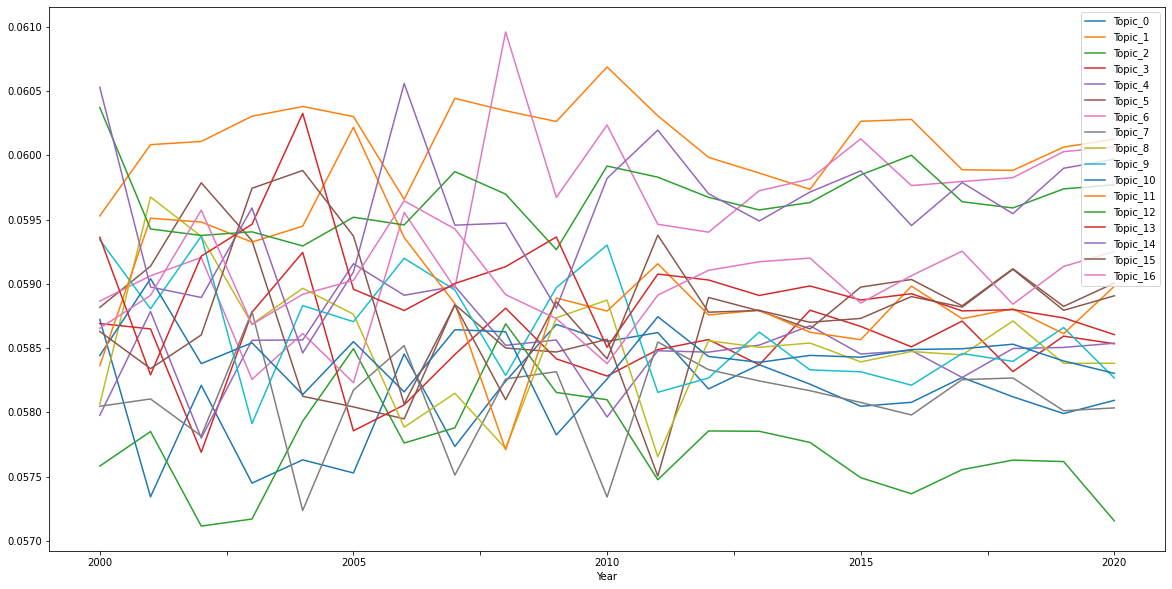

In [83]:
# Topic distribution over year graph
df_joined_year = df.groupby(['Year']).mean()
df_joined_year.plot(figsize=(20,10))
df_joined_year

<AxesSubplot:>

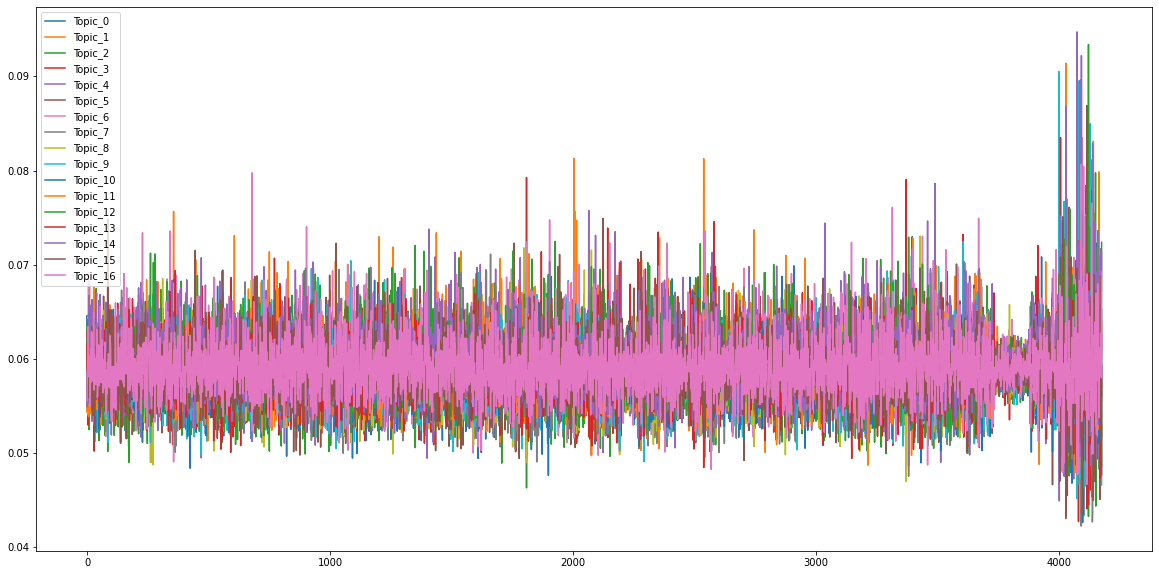

In [84]:
df.plot(figsize=(20,10))

In [76]:
df_document_per_topic.sort_values('Perc_Documents')

Dominant_Topic                                     Topic_Keywords  \
3549               2  protocol, secure, party, computation, communic...   
75                 2  protocol, secure, party, computation, communic...   
492                2  protocol, secure, party, computation, communic...   
969                2  protocol, secure, party, computation, communic...   
2556               2  protocol, secure, party, computation, communic...   
...              ...                                                ...   
2733               6  browser, website, content, extension, popular,...   
659                6  browser, website, content, extension, popular,...   
656                6  browser, website, content, extension, popular,...   
669                6  browser, website, content, extension, popular,...   
1304               6  browser, website, content, extension, popular,...   

      Num_Documents  Perc_Documents  Year    Conf  
3549             86          0.0206  2019    IEEE  
75               86          0.0206  2012  Usenix  
492              86          0.0206  2016  Usenix  
969              86          0.0206  2019  Usenix  
2556             86          0.0206  2020     CSS  
...             ...             ...   ...     ...  
2733            498          0.1193  2006    IEEE  
659             498          0.1193  2017  Usenix  
656             498          0.1193  2017  Usenix  
669             498          0.1193  2018  Usenix  
1304            498          0.1193  2012     CSS  

[4175 rows x 6 columns]

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Conf Year                                                               
CSS  2012  0.058177  0.060476  0.057953  0.058236  0.058230  0.059233   
     2013  0.057990  0.060182  0.057954  0.058041  0.058221  0.059042   
     2014  0.057865  0.060265  0.057639  0.059109  0.058441  0.058879   
     2015  0.057955  0.060653  0.057559  0.058552  0.058419  0.059119   
     2016  0.057644  0.060799  0.057537  0.058580  0.058475  0.059047   
     2017  0.058287  0.060125  0.057411  0.058708  0.058450  0.059029   
     2018  0.057909  0.059823  0.057890  0.058276  0.058720  0.059130   
     2019  0.058301  0.059870  0.057766  0.058497  0.058573  0.059126   
     2020  0.058358  0.060051  0.057183  0.058812  0.058471  0.059626   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Conf Year                                                               
CSS  2012  0.059138  0.058180  0.058096  0.058257  0.058125  0.058507   
     2013  0.059653  0.057533  0.058734  0.058818  0.058317  0.058759   
     2014  0.059892  0.058444  0.058397  0.058210  0.058240  0.058336   
     2015  0.059720  0.058203  0.058336  0.058458  0.058267  0.058745   
     2016  0.059709  0.058076  0.058430  0.058159  0.058481  0.059084   
     2017  0.059942  0.058172  0.058216  0.058366  0.058597  0.058758   
     2018  0.059740  0.058194  0.058522  0.058233  0.058870  0.058723   
     2019  0.059428  0.058199  0.058215  0.058292  0.058736  0.058781   
     2020  0.059744  0.058244  0.058065  0.058184  0.058629  0.058935   

           Topic_12  Topic_13  Topic_14  Topic_15  Topic_16  
Conf Year                                                    
CSS  2012  0.060162  0.059069  0.060127  0.058503  0.059532  
     2013  0.060186  0.058959  0.059900  0.058552  0.059159  
     2014  0.059561  0.058996  0.059712  0.058701  0.059314  
     2015  0.059681  0.059009  0.059785  0.058880  0.058659  
     2016  0.060238  0.059056  0.059077  0.058846  0.058762  
     2017  0.059370  0.058862  0.059603  0.059074  0.059030  
     2018  0.059713  0.058629  0.059601  0.059335  0.058692  
     2019  0.059553  0.059023  0.059559  0.059069  0.059013  
     2020  0.059902  0.059011  0.059275  0.058588  0.058923

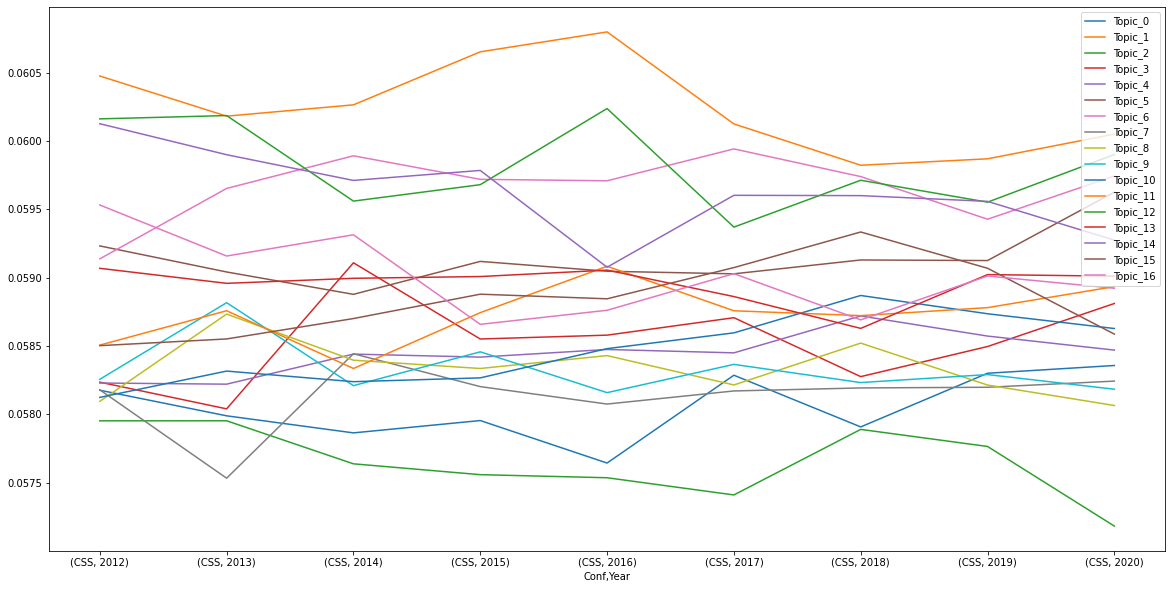

In [85]:
# Topic distribution over year graph for CSS
df_css = df[df['Conf'] == 'CSS'].groupby(['Conf', 'Year']).mean()
df_css.plot(figsize=(20,10))
df_css

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
Year                                                                         
2000  0.058723  0.059529  0.057582  0.058692  0.057977  0.058817  0.058866   
2001  0.057343  0.060084  0.057851  0.058650  0.058785  0.059138  0.059063   
2002  0.058210  0.060109  0.057115  0.057690  0.057800  0.059787  0.059206   
2003  0.057449  0.060305  0.057170  0.058779  0.058561  0.059337  0.058257   
2004  0.057630  0.060381  0.057932  0.059245  0.058564  0.058125  0.058614   
2005  0.057528  0.060303  0.058496  0.057856  0.059157  0.058043  0.058231   
2006  0.058455  0.059659  0.057761  0.058058  0.058912  0.057950  0.059556   
2007  0.057735  0.060445  0.057880  0.058451  0.058981  0.058840  0.058968   
2008  0.058243  0.060348  0.058689  0.058811  0.058522  0.058501  0.060962   
2009  0.058685  0.060265  0.058155  0.058416  0.058564  0.058470  0.059673   
2010  0.058553  0.060689  0.058098  0.058283  0.057964  0.058569  0.060237   
2011  0.058621  0.060309  0.057475  0.058489  0.058479  0.057504  0.059464   
2012  0.057192  0.059621  0.057650  0.058449  0.058060  0.058694  0.060078   
2013  0.058406  0.059976  0.057544  0.058701  0.058330  0.058679  0.059682   
2014  0.058837  0.059018  0.057361  0.058406  0.058570  0.058574  0.060067   
2015  0.057784  0.059949  0.057222  0.059400  0.058852  0.058886  0.060114   
2016  0.058342  0.060054  0.057311  0.058163  0.058791  0.058964  0.060203   
2017  0.058104  0.059818  0.057324  0.058871  0.058077  0.059188  0.059774   
2018  0.058320  0.059732  0.057265  0.058441  0.058154  0.059350  0.060242   
2019  0.057593  0.060197  0.057561  0.058401  0.058847  0.058577  0.059830   
2020  0.057947  0.059688  0.057972  0.058541  0.058443  0.059012  0.059704   

       Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
Year                                                                         
2000  0.058047  0.058064  0.059344  0.058443  0.058364  0.060373  0.059363   
2001  0.058104  0.059676  0.058806  0.059041  0.059511  0.059428  0.058292   
2002  0.057816  0.059370  0.059372  0.058379  0.059482  0.059377  0.059216   
2003  0.058786  0.058687  0.057913  0.058542  0.059326  0.059405  0.059464   
2004  0.057236  0.058966  0.058831  0.058138  0.059449  0.059296  0.060327   
2005  0.058174  0.058764  0.058706  0.058551  0.060220  0.059519  0.058958   
2006  0.058519  0.057885  0.059200  0.058160  0.059361  0.059459  0.058793   
2007  0.057511  0.058149  0.058952  0.058644  0.058846  0.059874  0.059003   
2008  0.058260  0.057719  0.058288  0.058627  0.057709  0.059699  0.059134   
2009  0.058317  0.058736  0.058971  0.057825  0.058890  0.059267  0.059365   
2010  0.057341  0.058874  0.059302  0.058260  0.058789  0.059918  0.058506   
2011  0.058548  0.057655  0.058156  0.058745  0.059157  0.059831  0.059077   
2012  0.058424  0.059023  0.058118  0.058780  0.058730  0.060000  0.059139   
2013  0.058097  0.058394  0.058690  0.058598  0.058902  0.059680  0.058928   
2014  0.057628  0.058473  0.058741  0.058586  0.058576  0.059935  0.058951   
2015  0.058210  0.058297  0.058720  0.058703  0.058443  0.059519  0.058512   
2016  0.057590  0.058330  0.058415  0.058459  0.058784  0.059976  0.058569   
2017  0.057915  0.058255  0.058781  0.058428  0.058298  0.060239  0.059144   
2018  0.058292  0.058970  0.058457  0.058244  0.058677  0.059437  0.058712   
2019  0.057690  0.058615  0.058643  0.058728  0.058836  0.059365  0.058507   
2020  0.058006  0.058705  0.058450  0.058444  0.058936  0.059407  0.058866   

      Topic_14  Topic_15  Topic_16  
Year                                
2000  0.060530  0.058629  0.058655  
2001  0.058976  0.058340  0.058911  
2002  0.058894  0.058603  0.059574  
2003  0.059591  0.059745  0.058684  
2004  0.058462  0.059883  0.058919  
2005  0.059093  0.059373  0.059027  
2006  0.060560  0.058066  0.059647  
2007  0.059457  0.058836  0.059428  
2008  0.059473  0.058099  0.058916  
2009  0.05

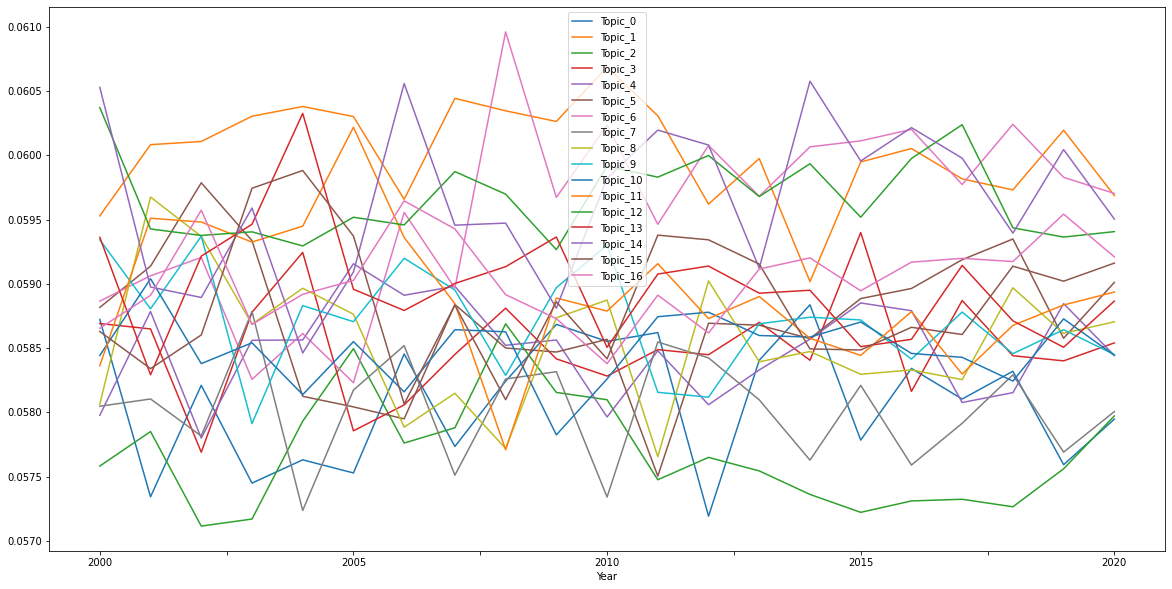

In [86]:
# Topic distribution over year graph for IEEE
df_ieee = df[df['Conf'] == 'IEEE'].groupby(['Year']).mean()
df_ieee.plot(figsize=(20,10))
df_ieee

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
Year                                                                         
2012  0.058574  0.059906  0.057684  0.058832  0.058825  0.058822  0.059379   
2013  0.058604  0.059753  0.057691  0.058466  0.058973  0.058609  0.060035   
2014  0.058246  0.059835  0.057892  0.058736  0.058842  0.058440  0.059837   
2015  0.058344  0.059795  0.057632  0.058357  0.058132  0.058851  0.060605   
2016  0.058397  0.059824  0.057200  0.058697  0.058248  0.059055  0.059477   
2017  0.058192  0.059484  0.057894  0.058625  0.058207  0.058258  0.059828   
2018  0.058242  0.060043  0.057551  0.058289  0.058450  0.058966  0.059677   
2019  0.058078  0.059917  0.057693  0.058792  0.058435  0.058723  0.060094   
2020  0.058183  0.060314  0.057367  0.058262  0.058669  0.058392  0.060199   

       Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
Year                                                                         
2012  0.058399  0.058573  0.058229  0.058419  0.058916  0.059228  0.059160   
2013  0.058619  0.058149  0.058511  0.058152  0.058751  0.059109  0.058862   
2014  0.058024  0.058535  0.058102  0.058563  0.058843  0.059756  0.059120   
2015  0.057781  0.058742  0.057968  0.058460  0.058606  0.060372  0.058713   
2016  0.058147  0.058643  0.058104  0.058519  0.059018  0.059734  0.059040   
2017  0.058556  0.058898  0.058447  0.058546  0.058953  0.059746  0.058372   
2018  0.058337  0.058771  0.058545  0.058320  0.058976  0.059547  0.059043   
2019  0.058254  0.058525  0.058615  0.058241  0.058700  0.059809  0.058685   
2020  0.058257  0.058551  0.058406  0.058298  0.058914  0.059586  0.058726   

      Topic_14  Topic_15  Topic_16  
Year                                
2012  0.059433  0.058606  0.059017  
2013  0.059491  0.058817  0.059408  
2014  0.059423  0.058706  0.059098  
2015  0.059943  0.058562  0.059140  
2016  0.059347  0.059172  0.059379  
2017  0.059823  0.058691  0.059480  
2018  0.059577  0.058851  0.058814  
2019  0.059408  0.058669  0.059363  
2020  0.059797  0.058959  0.059119

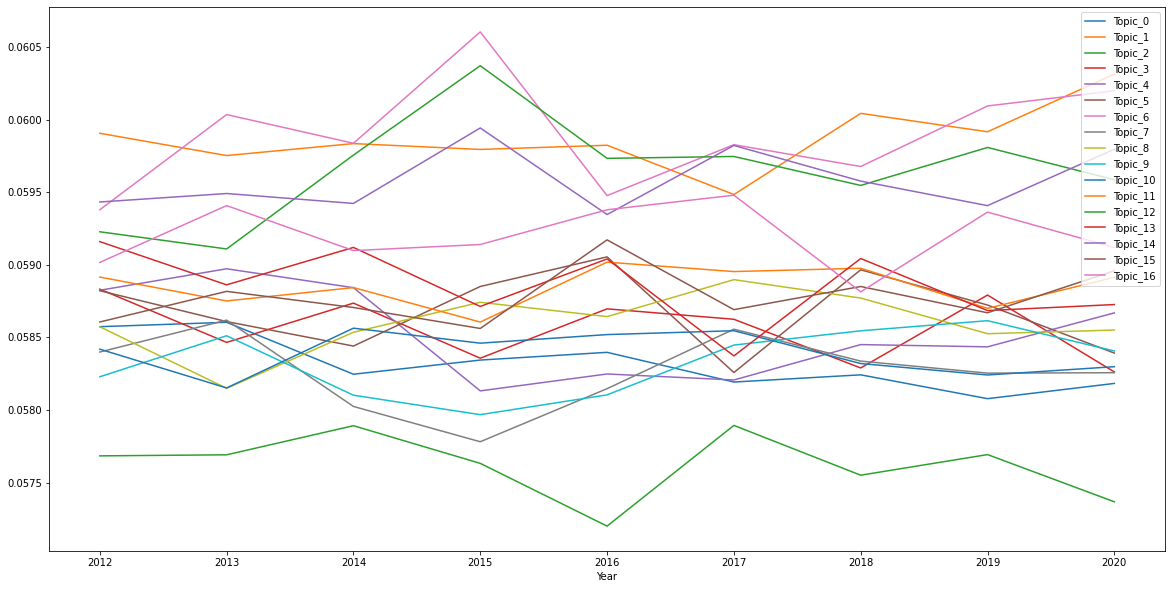

In [87]:
# Topic distribution over year graph for USENIX
df_usenix = df[df['Conf'] == 'Usenix'].groupby(['Year']).mean()
df_usenix.plot(figsize=(20,10))
df_usenix

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
Year                                                                         
2012  0.058565  0.059585  0.058344  0.058800  0.058670  0.058598  0.059134   
2013  0.058626  0.059286  0.058388  0.058400  0.058496  0.058796  0.059309   
2014  0.058174  0.059202  0.058441  0.058675  0.059086  0.058609  0.059197   
2015  0.058244  0.060355  0.057458  0.058430  0.058500  0.058874  0.060631   
2016  0.060000  0.059114  0.057137  0.057596  0.059173  0.060981  0.062596   
2017  0.058615  0.060130  0.057594  0.058672  0.058166  0.058923  0.059359   
2019  0.057641  0.060639  0.057195  0.058679  0.058022  0.058676  0.061573   
2020  0.057751  0.060534  0.055185  0.058796  0.058480  0.059629  0.060825   

       Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
Year                                                                         
2012  0.058380  0.058917  0.058591  0.058701  0.058960  0.059259  0.058476   
2013  0.059133  0.058914  0.058379  0.058729  0.058820  0.059136  0.058883   
2014  0.058562  0.059028  0.058527  0.058513  0.058984  0.059111  0.058711   
2015  0.057979  0.058117  0.057830  0.058458  0.058118  0.059993  0.059308   
2016  0.059318  0.057804  0.060195  0.058842  0.057893  0.059444  0.057903   
2017  0.058347  0.058459  0.058296  0.058200  0.058789  0.059361  0.058937   
2019  0.057533  0.058155  0.059635  0.057490  0.057733  0.060551  0.058485   
2020  0.057242  0.057863  0.057728  0.057614  0.059292  0.060674  0.057279   

      Topic_14  Topic_15  Topic_16  
Year                                
2012  0.058916  0.059064  0.059041  
2013  0.059153  0.058747  0.058805  
2014  0.059058  0.059001  0.059120  
2015  0.059950  0.058947  0.058808  
2016  0.058728  0.056656  0.056622  
2017  0.059986  0.058654  0.059512  
2019  0.061502  0.058098  0.058395  
2020  0.062190  0.058796  0.060124

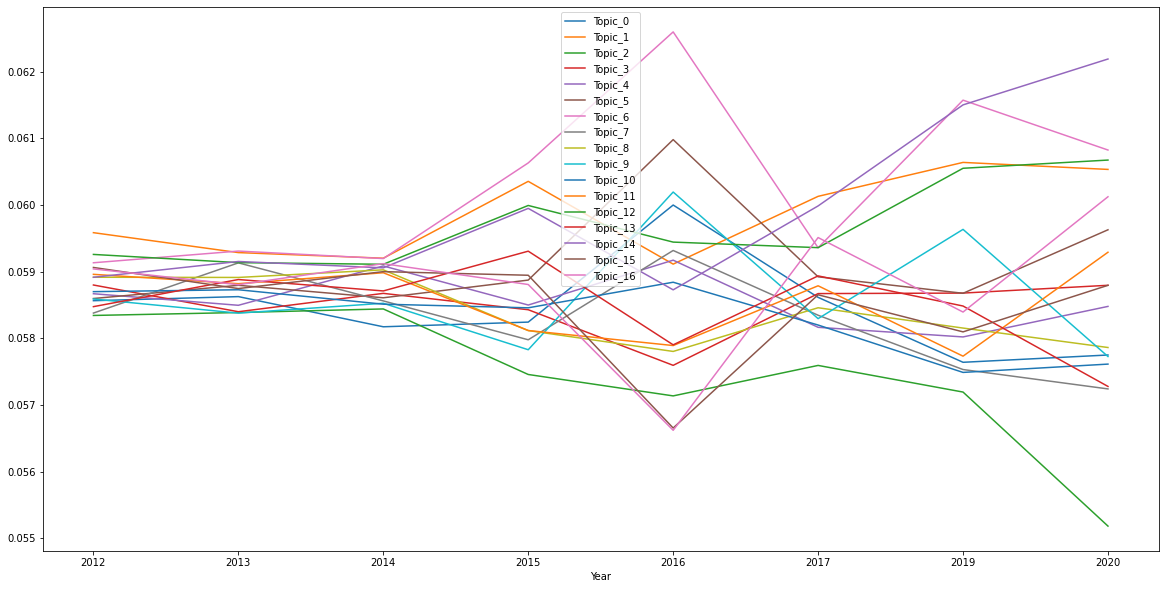

In [88]:
# Topic distribution over year graph for NDSS
df_ndss = df[df['Conf'] == 'NDSS'].groupby(['Year']).mean()
df_ndss.plot(figsize=(20,10))
df_ndss